# Explanation of `lcparam_full_long.txt`

The file `lcparam_full_long.txt` contains a table of key parameters recovered from light-curve fits for the full Pantheon sample of Type Ia supernovae. The Pantheon sample is a compilation of supernova observations used to study cosmology, particularly to understand the expansion of the universe.

## Columns in the File

1. **name**: The identifier for the supernova.
2. **zcmb**: The redshift of the supernova in the Cosmic Microwave Background (CMB) frame.
3. **zhel**: The heliocentric redshift of the supernova.
4. **dz**: The uncertainty in the redshift.
5. **mb**: The B-band peak magnitude of the supernova.
6. **dmb**: The uncertainty in the B-band peak magnitude.
7. **x1**: The stretch parameter (describes the shape of the light curve).
8. **dx1**: The uncertainty in the stretch parameter.
9. **color**: The color parameter (describes the color of the supernova).
10. **dcolor**: The uncertainty in the color parameter.
11. **3rdvar**: A third variable related to the supernova (often used for additional corrections).
12. **d3rdvar**: The uncertainty in the third variable.
13. **cov_m_s**: Covariance between the B-band magnitude and the stretch parameter.
14. **cov_m_c**: Covariance between the B-band magnitude and the color parameter.
15. **cov_s_c**: Covariance between the stretch parameter and the color parameter.
16. **set**: The data set the supernova belongs to.
17. **ra**: The right ascension of the supernova.
18. **dec**: The declination of the supernova.
19. **biascor**: The bias correction applied to the supernova data.

## Use in Cosmology

These parameters are crucial for determining the distances to the supernovae and for constructing the Hubble diagram, which is used to study the expansion history of the universe. The redshift provides a measure of how much the universe has expanded since the light left the supernova, while the B-band peak magnitude (after corrections) gives the luminosity distance. The stretch and color parameters are used to correct the observed magnitudes for various effects. Covariances provide information on how the uncertainties in these parameters are related.


Using CAMB 1.5.4 installed at /Users/marigalla/AstroCosmoComputational/Students/MariaLuisaGallavotti/CAMB/camb
     name     zcmb     zhel   dz        mb      dmb  x1  dx1  color  dcolor  \
0  03D1au  0.50309  0.50309  0.0  22.93445  0.12605   0    0      0       0   
1  03D1ax  0.49480  0.49480  0.0  22.88020  0.11765   0    0      0       0   
2  03D1co  0.67767  0.67767  0.0  24.03770  0.20560   0    0      0       0   
3  03D1ew  0.86650  0.86650  0.0  24.34685  0.17385   0    0      0       0   
4  03D1fq  0.79857  0.79857  0.0  24.36050  0.17435   0    0      0       0   

   3rdvar  d3rdvar  cov_m_s  cov_m_c  cov_s_c  set  ra  dec  
0       0        0        0        0        0    0   0    0  
1       0        0        0        0        0    0   0    0  
2       0        0        0        0        0    0   0    0  
3       0        0        0        0        0    0   0    0  
4       0        0        0        0        0    0   0    0  
Covariance Matrix (Sigma):
[[0.0158886  0.

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [00:27<00:00, 72.21it/s]


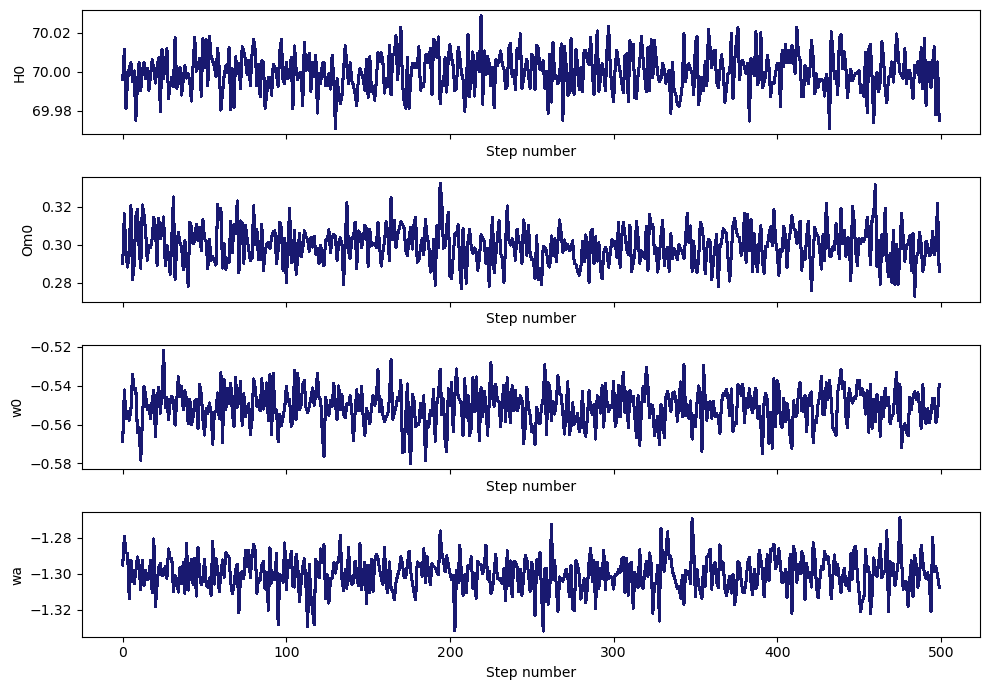

Autocorrelation times: [0.91880665]


In [101]:
import sys,platform,os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
sys.path.insert(0,_camb_path)

import camb
print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Check the data and covariance matrix
print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

# Define the cosmological model
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)

    # check for phantom divide crossing
    z=data['zcmb'].values
    w=w0+wa*(z/(1+z))
    if np.any(w<-1):
        print('Phantom divide crossed at redshifts:',z[w>-1])
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu = get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        #print(f"Error in get_mu: {e}")
        return -np.inf
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

'''
# Modify the prior range for w0 to exclude values close to -1
def log_prior(params):
    H0, Om0, w0, wa = params
    if 0 < H0 < 100 and 0 < Om0 < 1 and -2 < w0 < -0.5 and -2 < wa < 2:
        return 0.0
    print(f"Invalid prior for params: {params}")
    return -np.inf
'''

def log_prior(params):
    H0, Om0, w0, wa = params
    
    # Basic parameter bounds
    if not (60 < H0 < 80):
        print(f"Invalid H0: {H0}")
        return -np.inf
    if not (0 < Om0 < 1):
        print(f"Invalid Om0: {Om0}")
        return -np.inf
    if not (-2 < w0 < 1):
        print(f"Invalid w0: {w0}")
        return -np.inf
    if not (-2 < wa < 1):
        print(f"Invalid wa: {wa}")
        return -np.inf
    
    '''
    # Ensure w does not cross -1 at any redshift
    z = data['zcmb'].values
    w = w0 + wa * (z / (1 + z))
    if np.any(w > -1):
        crossing_indices = np.where(w > -1)[0]
        crossing_redshifts = z[crossing_indices]
        print(f"w is > -1 at redshifts: {crossing_redshifts}")
        return -np.inf
    '''
    '''
    # Constraint to avoid crossing w = -1 (relaxed)
    if w0 + wa > -1:
        print(f"w0 + wa > -1: {w0 + wa} -> invalid")
        #return -np.inf
    if w0 + wa < -1:
        #print(f"w0 + wa < -1: {w0 + wa} -> ok")
        return -np.inf
    '''
    '''
    # Constraint to ensure w_0 + w_a ≤ 0 at high redshift (relaxed)
    if w0 + wa > 0.5:
        print(f"Invalid w0 + wa (>0.5): {w0 + wa}")
        return -np.inf
    '''

    return 0.0

# Define the log-posterior function
def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Initialize the MCMC sampler
initial = np.array([70, 0.3, -0.55, -1.3])
ndim = len(initial)
nwalkers = 500
#pos = initial + 1e-1 * np.random.randn(nwalkers, ndim)

# Separate standard deviations for different parameter groups
std_H0_Om0 = 1e-2
std_w0_wa = 1e-2

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_H0_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_H0_Om0 * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)


'''
# Check initial likelihoods
print("Initial log-posterior values:")
for i in range(nwalkers):
    print(f"Walker {i}: {log_posterior(pos[i], data, Sigma_inv)}")
'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 2000  # Increase the number of steps
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100,thin=10,flat=True)

# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "Om0", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="midnightblue", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()

# Convergence diagnostics
from emcee import autocorr

# Compute the autocorrelation time for each parameter
tau = autocorr.integrated_time(sampler.get_chain(flat=True))
print("Autocorrelation times:", tau)


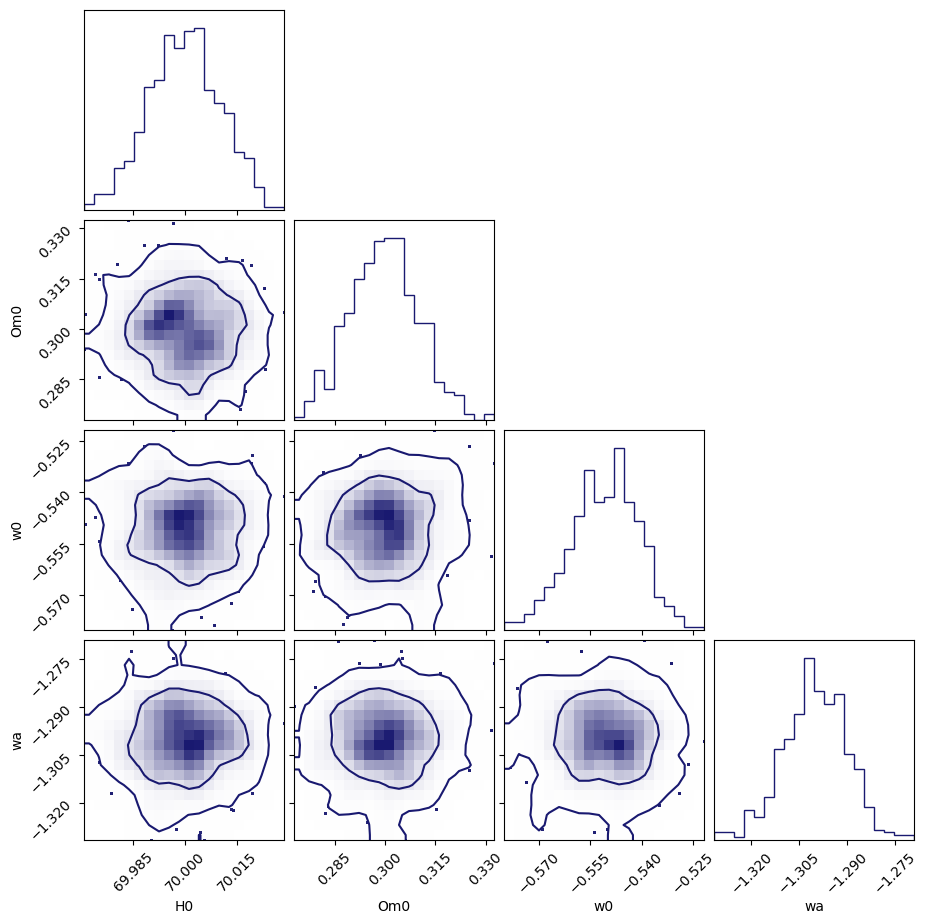

In [102]:
# Plot the results
fig = corner.corner(samples, color='midnightblue', labels=["H0", "Om0", "w0", "wa"], 
    smooth=1.0, 
    levels=[0.68, 0.95])
plt.show()
#'''

## Analisys

### Means and credible intervals (the 16th, 50th, and 84th percentiles) from the marginal distributions in the corner plot

In [86]:
percentiles = [16, 50, 84]
labels = ["H0", "Om0", "w0", "wa"]
estimates = np.percentile(samples, percentiles, axis=0)

results = {}
for i, label in enumerate(labels):
    q16, q50, q84 = estimates[:, i]
    results[label] = (q50, q84-q50, q50-q16)
    print(f"Real {label}: {q50:.6f} (+{q84-q50:.6f}, -{q50-q16:.6f})")

Real H0: 69.999925 (+0.008735, -0.009011)
Real Om0: 0.300242 (+0.010267, -0.011046)
Real w0: -0.548941 (+0.009148, -0.009910)
Real wa: -1.299719 (+0.011243, -0.009503)


In [87]:
# Check the shape and some basic statistics of the samples
print("Samples shape:", samples.shape)
print("Mean of samples:", np.mean(samples, axis=0))
print("Standard deviation of samples:", np.std(samples, axis=0))


Samples shape: (95000, 4)
Mean of samples: [70.00003487  0.30023149 -0.54930923 -1.29959024]
Standard deviation of samples: [0.009342   0.0102424  0.00996451 0.01052957]


Using CAMB 1.5.4 installed at /Users/marigalla/AstroCosmoComputational/Students/MariaLuisaGallavotti/CAMB/camb


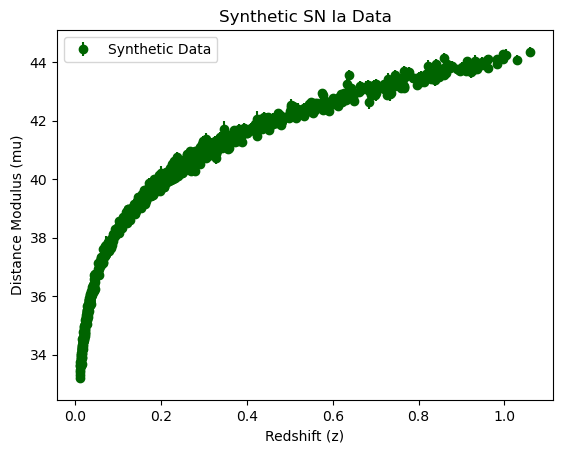

In [88]:
import sys,platform,os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
sys.path.insert(0,_camb_path)

import camb
print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z = data['zcmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Define fiducial cosmology parameters
fiducial_params = {
    'H0': 70.0,
    'Om0': 0.3,
    'w0': -0.55,
    'wa': -0.4
}

# Define the function to compute the distance modulus using CAMB
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Compute theoretical magnitudes using the fiducial cosmology
mu_theoretical = get_mu(z, **fiducial_params)

# Add Gaussian noise to the theoretical magnitudes
np.random.seed(42)  # For reproducibility
dmb = data['dmb'].values
mu_observed = mu_theoretical + np.random.normal(0, dmb)

# Create a new DataFrame with the synthetic data
synthetic_data = data.copy()
synthetic_data['mb'] = mu_observed

# Save synthetic data to a new file
synthetic_data.to_csv('synthetic_lcparam.txt', sep=' ', index=False)

# Plot the synthetic data
plt.errorbar(z, mu_observed, yerr=dmb, fmt='o', color='darkgreen', label='Synthetic Data')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.title('Synthetic SN Ia Data')
plt.legend()
plt.show()


In [89]:
# Assuming the log_posterior, ln_likelihood, and other necessary functions are already defined

# Load synthetic data
synthetic_file_path = 'synthetic_lcparam.txt'
synthetic_data = pd.read_csv(synthetic_file_path, sep='\s+')

# Extract relevant columns
d_syn = synthetic_data['mb'].values
dmb_syn = synthetic_data['dmb'].values
z_syn = synthetic_data['zcmb'].values

# Compute the covariance matrix
Sigma_syn = np.diag(dmb_syn**2)
Sigma_inv_syn = np.linalg.inv(Sigma_syn)

# Re-initialize the walkers for synthetic data
initial = np.array([70, 0.3, -0.55, -1.3])
ndim = len(initial)
nwalkers = 500
#pos = initial + 1e-1 * np.random.randn(nwalkers, ndim)

# Separate standard deviations for different parameter groups
std_H0_Om0 = 1e-2
std_w0_wa = 1e-2

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_H0_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_H0_Om0 * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)

# Initialize the MCMC sampler for synthetic data
sampler_syn = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(synthetic_data, Sigma_inv_syn))

# Run the MCMC sampler
nsteps = 2000
sampler_syn.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples_syn = sampler_syn.get_chain(discard=100, thin=10, flat=True)

# Calculate the percentiles for synthetic data
percentiles = [16, 50, 84]
labels = ["H0", "Om0", "w0", "wa"]
estimates_syn = np.percentile(samples_syn, percentiles, axis=0)

# Display the results
results_syn = {}
for i, label in enumerate(labels):
    q16, q50, q84 = estimates_syn[:, i]
    results_syn[label] = (q50, q84-q50, q50-q16)
    print(f"Synthetic {label}: {q50:.6f} (+{q84-q50:.6f}, -{q50-q16:.6f})")

# Display the results from real data
print("\nResults from real data:")
for label, (q50, q84_minus_q50, q50_minus_q16) in results.items():
    print(f"{label}: {q50:.6f} (+{q84_minus_q50:.6f}, -{q50_minus_q16:.6f})")

# Compare the results from real and synthetic data
print("\nComparison:")
for label in labels:
    real_q50, real_q84_minus_q50, real_q50_minus_q16 = results[label]
    syn_q50, syn_q84_minus_q50, syn_q50_minus_q16 = results_syn[label]
    print(f"{label}: Real: {real_q50:.6f} (+{real_q84_minus_q50:.6f}, -{real_q50_minus_q16:.6f}) "
          f"vs Synthetic: {syn_q50:.6f} (+{syn_q84_minus_q50:.6f}, -{syn_q50_minus_q16:.6f})")


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [00:27<00:00, 73.43it/s]

Synthetic H0: 70.000802 (+0.010344, -0.010491)
Synthetic Om0: 0.299796 (+0.009973, -0.009028)
Synthetic w0: -0.549963 (+0.008936, -0.009869)
Synthetic wa: -1.300312 (+0.010086, -0.009181)

Results from real data:
H0: 69.999925 (+0.008735, -0.009011)
Om0: 0.300242 (+0.010267, -0.011046)
w0: -0.548941 (+0.009148, -0.009910)
wa: -1.299719 (+0.011243, -0.009503)

Comparison:
H0: Real: 69.999925 (+0.008735, -0.009011) vs Synthetic: 70.000802 (+0.010344, -0.010491)
Om0: Real: 0.300242 (+0.010267, -0.011046) vs Synthetic: 0.299796 (+0.009973, -0.009028)
w0: Real: -0.548941 (+0.009148, -0.009910) vs Synthetic: -0.549963 (+0.008936, -0.009869)
wa: Real: -1.299719 (+0.011243, -0.009503) vs Synthetic: -1.300312 (+0.010086, -0.009181)
